In [2]:
# This notebook uses a nomogram available on the web to create an additional feature for patients
# The nomogram is available at https://nomograms.mskcc.org/Breast/BreastSLNodeMetastasisPage.aspx
# The filling and submitting of the webform is automated using the 'pyautogui' module
from pyautogui import * 
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snsd
import pyperclip

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', True)

nomogram_url = "https://nomograms.mskcc.org/Breast/BreastSLNodeMetastasisPage.aspx"
raw_data_path = "/Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/output/2022-07-15-102348_without_imputation_fixed/DataFrames/Dataset-expert-imputed.csv"
nomogram_output_path = "/Users/yifu/PycharmProjects/Radiotherapy-Prediction/notebooks/data/nomogram_data/nomogram_results_2022-07-19_debugged.csv"

In [2]:
# Load raw data
df = pd.read_csv(raw_data_path)
df.head()

,PRE_record_id,PRE_dob,PRE_age_at_dx,PRE_age_at_surg,PRE_men_status,PRE_fmhx,PRE_gensus___brca1,PRE_gensus___brca2,PRE_gensus___p53,PRE_gensus___pten,PRE_gensus___other,PRE_gensus___unknown,PRE_gensus___no_gensus,PRE_systhe___chemo,PRE_systhe___hormonal,PRE_systhe___chemo_and_hormonal,PRE_systhe___no_systhe,PRE_systhe___radiation,PRE_tumor_laterality,PRE_height_cm,PRE_bmi,PRE_weight_kg,PRE_bra_cup_size,PRE_palpability,PRE_axillary_lymph_node_palpab,PRE_dximg___mammography,PRE_dximg___ultrasound,PRE_dximg___mri,PRE_dximg_date,PRE_bi_rads_score,PRE_img_size,PRE_tumor_max_size_composite,PRE_foci,PRE_tumor_stge,PRE_abnormal_lymph,PRE_susp_LN_prsnt_composite,PRE_lymph_node_max_size_mm,PRE_susp_LN_size_composite,PRE_tumor_size_mm,PRE_microcalcifications,PRE_extent_of_calcification_ma,PRE_prominent_axillary_lymph,PRE_lymph_node_max_size_mm0,PRE_backgroun_enhancement,PRE_max_enhancement_measurment,PRE_axillary_lymphadenopathy,PRE_internal_mammary_lymphaden,PRE_high_grade_fdg_foci_presen,PRE_size_of_the_largest_foci_c,PRE_axillary_lymphadenopathy_p,PRE_axillary_lymph_node_max_si,PRE_int_mammary_lymphade_pet,PRE_internal_mammary_lymph_nod,PRE_pre_op_biop_date,PRE_pre_op_biopsy,PRE_tumor_location,PRE_tumor_location_trans,PRE_his_subtype___idc,PRE_his_subtype___ilc,PRE_his_subtype___dcis,PRE_his_subtype___lcis,PRE_his_subtype___inv_mucinous,PRE_his_subtype___papillary,PRE_specify_histology_if_non_o,PRE_tumor_grade,PRE_margin_status,PRE_closest_margin,PRE_num_closest_margins_trans,PRE_distance_from_closest_marg,PRE_lymphovascular_invasion0,PRE_er_status,PRE_pr_status,PRE_her_status,PRE_imaging_and_biopsy_concord,PRE_axillary_lymph_node_core_b,PRE_metastatic_carcinoma_on_ax,PRE_surg_indicat_prim___primary_tx,PRE_surg_indicat_prim___reexcis_marg+_bcs,PRE_surg_indicat_prim___compl_mast_marg+_bcs,PRE_surg_indicat_prim___recurrent_cancer,PRE_surg_indicat_prim___second_primary,PRE_laterality,PRE_surgery_date,PRE_breast_procedure,PRE_ax_surg___no_ax_surg,PRE_ax_surg___sln_biopsy,PRE_ax_surg___ax_ln_dissect,INT_lymph_nodes,INT_sln,POS_number_of_positive_sln,POS_ax_nodes,POS_mastectomy_weight_g,POS_tumor_size,POS_tumor_loc,POS_tumor_location_trans,POS_his_type___idc,POS_his_type___ilc,POS_his_type___dcis,POS_his_type___lcis,POS_his_type___other,POS_his_type___no_residual,POS_his_type___inv_mucinous,POS_his_type___inv_papillary,POS_specify_histology_if_other,POS_tu_grade,POS_tumor_focality,POS_num_foci,POS_lymphovascular_invasion,POS_in_situ_component_present,POS_in_situ_component_type___dcis,POS_in_situ_component_type___lcis,POS_in_situ_component_size_mm,POS_in_situ_component_grade,POS_mar_status,POS_clos_margin___posterior,POS_clos_margin___anterior,POS_clos_margin___medial,POS_clos_margin___lateral,POS_clos_margin___inferior,POS_clos_margin___superior,POS_clos_margin___other,POS_dis_closest_margin,POS_metastasis,POS_ln_w_micrometastasis,POS_ln_w_macrometastasis,POS_size_of_largest_nodal_meta,POS_extranodal_extension,POS_extent_of_extranodal_exten,POS_did_the_patient_receive_pm,POS_did_the_patient_reject_pmr,POS_data_collection_fields_complete
0,292.0,1966,51.0,51.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,1,0,2.0,NaN,NaN,NaN,NaN,0.0,0,1,1,0,2017.0,4.3,31.0,31.0,1,NaN,0,0,NaN,0.0,NaN,1.0,9.0,2,NaN,2,0.0,0,0,NaN,NaN,0,NaN,0,0,2017.0,1.0,NaN,NaN,0,0,1,0,0,0,NaN,2.0,NaN,NaN,NaN,NaN,0,1.0,1.5,1.5,NaN,0,0.0,1,0,0,0,0,2.0,2017.0,2.0,0,1,0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,2.0,1.0,1,0,25.0,2.0,1.0,0,0,0,0,0,0,1,0.25,2.0,NaN,NaN,NaN,2.0,NaN,1.0,0.0,2
1,491.0,1948,66.0,66.0,2.0,0.0,0,0,0,0,0,1,0,0,0,0,1,0,1.0,157.0,25.964542,64.0,NaN,1.0,0,1,1,0,2014.0,NaN,7.0,15.0,1,NaN,0,0,NaN,0.0,15.0,1.0,0.0,2,NaN,2,0.0,0,0,NaN,NaN,0,NaN,0,0,2014.0,2.0,NaN,NaN,0,1,0,0,0,0,NaN,2.0,1.0,NaN,2.0,NaN,0,1.0,1.0,2.0,1.0,0,0.0,0,0,1,0,0,1.0,2014.0,3.0,0,0,1,10.0,0.0,0.0,10.0,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,2.0,0,0,0,0,0,0,0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,0.0,2
2,296.0,1959,58.0,59.0,2.0,1.0,0,1,0,0,0,0,0,0,0,0,1,0,2.0,NaN,N

In [3]:
"""
Create a subset of columns required by nomogram

Nomogram website: https://nomograms.mskcc.org/Breast/BreastSLNodeMetastasisPage.aspx

The columns are:
Current Age (20 to 91 yrs)
    Enter current age. Must be between 20 and 91. 
Breast Tumor Size  (0.1 to 11.0 cm)
    Size of the primary tumor (as measured either in imaging study or pathological exam), in centimeters.
Special Type? (boolean)
    Check box if tumor has been pathologically defined as pure tubular, pure colloid (mucinous), or typical medullary carcinomas
    on the pathology report. Other histologies such as atypical medullary carcinoma or carcinoma with ductal and lobular features should 
    be classified as ductal -- see Tumor Type and Grade section below for more details.
Tumor is confined to UIQ? (boolean)
    Check box if tumor is confined within the upper inner quadrant (UIQ) of the breast.
Lymphatic or Vascular Structure Involvement (boolean)
    Check box if one or more tumor cells found in the blood or lymphatic vessels.
Multifocality? (boolean)
    Check box if breast cancer has cancer cells seperated from the main tumor mass.
Tumor Type and Grade (Ductal I, Ductal II, Ductal III, Lobular)
    Indicate if tumor type is ductal or lobular, as noted in the pathology report.
    If ductal, indicate the nuclear grade -- 
        I: slight or no variation in the size and shape of the nucleus;
        II: moderate variation in the size and shape of the nucleus;
        III: marked variation in the size and shape of the nucleus.
Estrogen-Receptor Status (Negative, Positive, Unknown)
    Select NEGATIVE if estrogen receptors stain positive in <10% of cells;
    Select POSITIVE if estrogen receptors stain positive in ≥10% of cells.
Progesterone-Receptor Status
    Select NEGATIVE if progesterone receptors stain positive in <10% of cells;
    select POSITIVE if progesterone receptors stain positive in ≥10% of cells.
"""

from typing import Optional, List

class FieldType:
    """
    Enum for field type
    """
    CHECKBOX = "CHECKBOX"
    DROPDOWN = "DROPDOWN"
    TEXTAREA = "TEXTAREA"
    RESULT = "RESULT"
    CALCULATE = "CALCULATE"
    CLEAR = "CLEAR"
    

class NomogramField:
    
    def __init__(self, web_field_name: str, web_field_type: FieldType, df_column_name: str, dropdown_options: List[str] = []) -> None:
        """Object for holding and structuring the information to fill the webform automatically

        Args:
            web_field_name (str): The name as it appears on the nomogram website
            web_field_type (FieldType): The type of the webform field
            df_column_name (str): The name of column in the local dataset
        """
        self.web_field_name = web_field_name
        self.web_field_type = web_field_type
        self.df_column_name = df_column_name
        self.webform_x_coord = None
        self.webform_y_coord = None
        self.dropdown_coords = None
        self.dropdown_options = dropdown_options
    
    def update_webform_coordinates(self) -> None:
        """
        Update the coordinates of the webform field using the current mouse location
        """
        field_type = self.web_field_type
        alert(
            f"Calibrating the screen coordinates of '{self.web_field_name}' on webform...\n"
            "\n\nINSTRUCTIONS:\n\n"
            "Place your mouse where the field can be filled, and press Enter without moving the mouse.\n" \
            "The very tip of the mouse pointer should be INSIDE the checkbox, text area, or drop down menu."
            "The location/scrolling of the webform should not be changed during the entire calibration process for all fields.",
            title=f"Calibrating Screen Coordinates",
            button="Press Enter while holding the mouse in place to continue"
            )
        self.webform_x_coord, self.webform_y_coord = position()
        alert(
            f"Coordinates of '{self.web_field_name}' updated: {self.webform_x_coord}, {self.webform_y_coord}",
            title="Coordinates Updated", 
            button="Press Enter to continue"
        )
        if field_type == FieldType.DROPDOWN:
            dropdown_coords = {}
            for option in self.dropdown_options:
                alert(
                    f"'{self.web_field_name}' is a dropdown menu, calibration is needed for each option available.\n"
                    "Please make sure the dropdown menu isn't chosen (completely blank)\n"
                    "Then, click the blank dropdown menu to open it.\n"
                    f"Then, hover the tip of the mouse pointer on the dropdown option for '{option}'\n"
                    "Then, mark the location of the tip of the mouse pointer on your screen using your finger or pen."
                    "Then, come back to this message box, click this box to make window active, and"
                    "hover your mouse back to the marked location. Lastly, press Enter to continue.\n",
                    button="Press Enter to continue",
                    title=f"Calibrating for {option}"
                )
                option_x_coord, option_y_coord = position()
                alert(
                    f"Coordinates of '{self.web_field_name}' = '{option}' updated: {option_x_coord}, {option_y_coord}",
                    title="Coordinates Updated", 
                    button="Press Enter to continue"
                )
                dropdown_coords[option] = (option_x_coord, option_y_coord)
            self.dropdown_coords = dropdown_coords
        elif field_type == FieldType.RESULT:
            result_coords = {}
            alert(
                "Move the cursor to the TOP-LEFT corner of the grey box where the nomogram will output the probabilities "
                "This script will drag across the area to select the resulting probability to be copied.",
                title="Calibrating for Dragging and Copying Result",
                button="Press Enter to continue"
            )
            result_coords["top_left"] = position()
            alert(
                "Move the cursor to the BOTTOM-RIGHT corner of the grey box where the nomogram will output the probabilities "
                "This script will drag across the area to select the resulting probability to be copied.",
                title="Calibrating for Dragging and Copying Result",
                button="Press Enter to continue"
            )
            result_coords["bottom_right"] = position()
            self.result_coords = result_coords

    # def fill_webform(self, web_field_name: str, row: pd.Series) -> str:
    #     """Given a row in dataframe, fill the field in webform

    #     Args:
    #         web_field_name (str): The name as it appears on the nomogram website
    #         row (pd.Series): The row in the dataframe
    #     Raises:
    #         ValueError: If the field is not supported, or if value is invalid
    #     """
    #     field_type = self.web_field_type
    #     df_column = self.df_column_name
    #     webform_x_coord = self.webform_x_coord
    #     webform_y_coord = self.webform_y_coord
    #     dropdown_coords = self.dropdown_coords
    #     value = row[df_column]
    #     if field_type == FieldType.CHECKBOX:
    #         if value == "True" and ...:
    #             raise NotImplementedError
    #             # Need to toggle the checkbox if it's previously unchecked
    #         elif value == "False":
    #             raise NotImplementedError
    #             # click(webform_x_coord, webform_y_coord)
    #     elif field_type == FieldType.DROPDOWN:
    #         doubleClick(webform_x_coord, webform_y_coord)
    #         doubleClick(webform_x_coord, webform_y_coord)
    #         time.sleep(0.1)
    #         x, y = self.get_dropdown_option_coords(value)
    #         click(x, y)
    #     elif field_type == FieldType.TEXTAREA:
    #         doubleClick(webform_x_coord, webform_y_coord)
    #         time.sleep(0.1)
    #         doubleClick(webform_x_coord, webform_y_coord)
    #         time.sleep(0.1)
    #         typewrite(value)
    #         time.sleep(0.1)
    #         press("enter")
    #     else:
    #         raise ValueError("Unsupported field type")
        
    def get_dropdown_option_coords(self, value: str):
        """Given a value, return the coordinates of the dropdown option

        Args:
            value (str): The value of the dropdown option
        Raises:
            ValueError: If the value is not supported
        """
        if value not in self.dropdown_options:
            raise ValueError(f"Unsupported dropdown option {value}.")
        else:
            return self.dropdown_coords[value]


    def fill_value(self, value: str) -> Optional[float]:
        """Fill the patient value in monogram, and if the field is RESULT, return the probability

        Args:
            value (str): value to be filled

        Raises:
            Exception: If the field is not supported

        Returns:
            Optional[float]: probability from the nomogram, within range [0, 1.00]
        """
        print(f"{self.web_field_name[:10]} = {value}\t|", end="\t")
        field_type = self.web_field_type
        webform_x_coord, webform_y_coord = self.webform_x_coord, self.webform_y_coord
        if field_type == FieldType.CLEAR:
            clear_field = nomogram_fields["Clear"]
            click(clear_field.webform_x_coord, clear_field.webform_y_coord)
            time.sleep(0.5)
            click(clear_field.webform_x_coord, clear_field.webform_y_coord)
            time.sleep(1)
        elif field_type == FieldType.TEXTAREA:
            doubleClick(webform_x_coord, webform_y_coord, interval=0.2)
            time.sleep(0.1)
            typewrite(value)
            # Press tab to clear auto-completes
            time.sleep(0.1)
            press("tab")
        elif field_type == FieldType.CHECKBOX:
            if value == "Yes":
                click(webform_x_coord, webform_y_coord)
        elif field_type == FieldType.DROPDOWN:
            click(webform_x_coord, webform_y_coord)
            time.sleep(0.1)
            option_x_coord, option_y_coord = self.get_dropdown_option_coords(value)
            time.sleep(0.1)
            click(option_x_coord, option_y_coord)
        elif field_type == FieldType.CALCULATE:
            click(webform_x_coord, webform_y_coord)
            time.sleep(1)
        elif field_type == FieldType.RESULT:
            top_left_coords = self.result_coords["top_left"]
            bottom_right_coords = self.result_coords["bottom_right"]
            moveTo(top_left_coords.x, top_left_coords.y)
            time.sleep(0.1)
            dragTo(bottom_right_coords.x, bottom_right_coords.y, duration=0.1, button="left")
            if os_type == "Windows":
                hotkey("ctrl", "c")
            elif os_type == "Mac":
                hotkey("command", "c")
            time.sleep(0.1)
            result = pyperclip.paste()
            if "%" in result:
                result = result.replace("%", "")
                result = round(float(result) / 100, 4)
                pyperclip.copy(result)
            print(f"The resulting probability is {result}")
        else:
            raise ValueError(f"Unknown field type: {field_type}")

        if field_type == FieldType.RESULT:
            return result
        
        
def get_value_from_patient(field, row: pd.Series) -> str:
    """Get the appropriate nomogram field value from patient's row of data

    Args:
        row (pd.series): patient's row of data in the dataframe
    
    Returns:
        str: the value for the nomogram field
    """
    field_name = field.web_field_name
    if field_name in ["Clear", "Calculate",]:
        return None
    elif field_name == "Current Age":
        # Use either age_at_dx if available, else age_at_surg 
        if str(row["PRE_age_at_dx"]) != "nan":
            age = row["PRE_age_at_dx"]
        # elif str(row["PRE_age_at_surg"]) != "nan":
        #     age = row["PRE_age_at_surg"]
        else:
            raise ValueError("No age available")
        # Ensure age in range [20, 91]
        if age < 20:
            age = 20
        elif age > 91:
            age = 91
        return str(age)
    elif field_name == "Breast Tumor Size":
        size = row["PRE_tumor_max_size_composite"]
        if str(size) == "nan":
            raise ValueError("No tumor size available")
        size = float(size) / 10
        # Ensure size in range [0.1, 11.0 cm]
        if size < 0.1:
            size = 0.1
        elif size > 11.0:
            size = 11.0
        return str(size)
    elif field_name == "Special Type?":
        is_mucinous = float(row["PRE_his_subtype___inv_mucinous"]) == 1
        if is_mucinous:
            return "Yes"
        else:
            return "No"
    elif field_name == "Tumor is confined to UIQ?":
        tumor_location_trans = row["PRE_tumor_location_trans"]
        if str(tumor_location_trans) == "nan":
            return "No"
        # left breast is positive, right breast is negative
        tumor_location_trans = int(tumor_location_trans)
        # if -12 <= tumor_location_trans <= -9  r tumor_location_trans == 12 or 0 < tumor_location_trans <= 3:
        # right breast UIQ: 12, 1, 2, 3 o' clock; left breast UIQ: 9, 10, 11, 12 o' clock
        if (tumor_location_trans in [-12, -1, -2, -3, 9, 10, 11, 12]):
            return "Yes"
        else:
            return "No"
    elif field_name == "Lymphatic or Vascular Structure Involvement (LymphovascularInvasion)":
        lvi = row["PRE_lymphovascular_invasion0"]
        if str(lvi) == "nan":
            raise ValueError("No lymphatic invasion available")
        elif float(lvi) == 0:
            return "No"
        else:
            return "Yes"
    elif field_name == "Multifocality?":
        focality = row["PRE_foci"]
        if str(focality) == "nan":
            raise ValueError("No focality available")
        elif int(focality) > 1:
            return "Yes"
        else:
            return "No"
    elif field_name == "Tumor Type and Grade":
        # is_lobular = float(row["PRE_his_subtype___2"]) == 1 or float(row["PRE_his_subtype___4"]) == 1
        # is_ductal =  float(row["PRE_his_subtype___1"]) == 1 or float(row["PRE_his_subtype___3"]) == 1
        is_lobular = float(row["PRE_his_subtype___ilc"]) == 1 or float(row["PRE_his_subtype___lcis"]) == 1
        is_ductal =  float(row["PRE_his_subtype___idc"]) == 1 or float(row["PRE_his_subtype___dcis"]) == 1
        if is_lobular and not is_ductal:
            return "Lobular"
        grade = str(row["PRE_tumor_grade"])
        if grade == "nan":
            raise ValueError("No grade available")
        elif float(grade) == 1:
            return "Ductal, I"
        elif float(grade) == 3:
            return "Ductal, III"
        else:
            return "Ductal, II"
    elif field_name == "Estrogen-Receptor Status":
        er_status = row["PRE_er_status"]
        if str(er_status) == "nan":
            raise ValueError("No estrogen receptor status available")
        elif float(er_status) == 1:
            return "Positive"
        elif float(er_status) == 2:
            return "Negative"
        else:
            return "Unknown"
    elif field_name == "Progesterone-Receptor Status":
        pr_status = row["PRE_pr_status"]
        if str(pr_status) == "nan":
            raise ValueError("No progesterone receptor status available")
        elif float(pr_status) == 1:
            return "Positive"
        elif float(pr_status) == 2:
            return "Negative"
        else:
            return "Unknown"
    else:
        raise ValueError(f"Unsupported field name {field_name}")
    

In [4]:
from collections import OrderedDict


nomogram_fields = OrderedDict({
    "Clear": NomogramField(
        web_field_name="Clear",
        web_field_type=FieldType.CLEAR,
        df_column_name=None
    ),
    "Current Age": NomogramField(
        web_field_name="Current Age",
        web_field_type=FieldType.TEXTAREA,
        df_column_name="nomogram_age"
    ),
    "Breast Tumor Size": NomogramField(
        web_field_name="Breast Tumor Size",
        web_field_type=FieldType.TEXTAREA,
        df_column_name="nomogram_max_tumor_size_composite"
    ),
    "Special Type?": NomogramField(
        web_field_name="Special Type?",
        web_field_type=FieldType.CHECKBOX,
        df_column_name="nomogram_is_special_type"
    ),
    "Tumor is confined...": NomogramField(
        web_field_name="Tumor is confined to UIQ?",
        web_field_type=FieldType.CHECKBOX,
        df_column_name="nomogram_tumor_confined_uiq"
    ),
    "Lymphatic or Vascular...": NomogramField(
        web_field_name="Lymphatic or Vascular Structure Involvement (LymphovascularInvasion)",
        web_field_type=FieldType.CHECKBOX,
        df_column_name="nomogram_is_lymphovascular_invasive"  # TODO whether to use POST LVI?
    ),
    "Multifocality?": NomogramField(
        web_field_name="Multifocality?",
        web_field_type=FieldType.CHECKBOX,
        df_column_name="nomogram_is_multifocal"
    ),
    "Tumor Type and Grade": NomogramField(
        web_field_name="Tumor Type and Grade",
        web_field_type=FieldType.DROPDOWN,
        df_column_name="nomogram_tumor_type_and_grade",
        dropdown_options=["Ductal, I", "Ductal, II", "Ductal, III", "Lobular"]
    ),
    "Estrogen-Receptor Status": NomogramField(
        web_field_name="Estrogen-Receptor Status",
        web_field_type=FieldType.DROPDOWN,
        df_column_name="nomogram_er_status",
        dropdown_options=["Negative", "Positive", "Unknown"]
    ),
    "Progesterone-Receptor Status": NomogramField(
        web_field_name="Progesterone-Receptor Status",
        web_field_type=FieldType.DROPDOWN,
        df_column_name="nomogram_pr_status",
        dropdown_options=["Negative", "Positive", "Unknown"]
    ),
    "Calculate": NomogramField(
        web_field_name="Calculate",
        web_field_type=FieldType.CALCULATE,
        df_column_name=None
    ),
    "Probability of SLN+": NomogramField(
        web_field_name="Probability of Spread to Sentinel Lymph Nodes (the area where the probability "
        "as a percentage will appear. Initially, it is an empty grey box, inside another grey box titled "
        "'Your Results' and to the right to the blue text 'Probability of Spread to Sentinel Lymph Nodes'.)",
        web_field_type=FieldType.RESULT,
        df_column_name=None
    )
})


def calibrate_coordinates(nomogram_fields: OrderedDict) -> None:
    """Given a dictionary of NomogramField objects, calibrate the coordinates of each field

    Args:
        nomogram_fields (Dict[str, NomogramField]): The dictionary of NomogramField objects
    """
    # Get the user's OS whether it's Windows or Mac
    global os_type
    if sys.platform == "win32":
        os_type = "Windows"
    elif sys.platform == "darwin":
        os_type = "Mac"
    else:
        raise ValueError("Unsupported OS")
    alert(f"The current OS is: {os_type}", title="OS Detected", button="Press Enter to continue")
    time.sleep(0.5)
    alert(
        "\n\nPlease have the webform on the right half of the screen, and the Excel spreadsheet on the left half.\n"
        "The webform should be scrolled to the *top-left* of the page.\n"
        "And the webform should be zoomed-out sufficiently so that all the fields (and also the probability in Your Results on the right) are visible without scrolling.\n"
        "Please do not move the browser or scroll the webform during the entire calibration process for all fields.\n\n"
        "When you are ready, click OK or press Enter to continue.",
        title="Starting Calibration...",
        button='OK (or press Enter)'
        )
    # For each field, update the coordinates of the webform field using the current mouse location
    for field in nomogram_fields.values():
        field.update_webform_coordinates()

    confirm("Calibration is complete.")
    time.sleep(1)
    # Print all the fields and their coordinates
    print("--- the coordinates of the webform fields are ---")
    for field in nomogram_fields.values():
        print(f"{field.web_field_name}: {field.webform_x_coord}, {field.webform_y_coord}")
    time.sleep(1)
    

calibrate_coordinates(nomogram_fields)

--- the coordinates of the webform fields are ---
Clear: 1114, 269
Current Age: 1030, 311
Breast Tumor Size: 1034, 347
Special Type?: 1019, 389
Tumor is confined to UIQ?: 1018, 492
Lymphatic or Vascular Structure Involvement (LymphovascularInvasion): 1018, 537
Multifocality?: 1019, 596
Tumor Type and Grade: 1036, 644
Estrogen-Receptor Status: 1047, 736
Progesterone-Receptor Status: 1053, 794
Calculate: 1194, 268
Probability of Spread to Sentinel Lymph Nodes (the area where the probability as a percentage will appear. Initially, it is an empty grey box, inside another grey box titled 'Your Results' and to the right to the blue text 'Probability of Spread to Sentinel Lymph Nodes'.): 1431, 329


In [5]:
# Clear webform

def test_fill(i):
    """
    Test filling the nomogram fields

    Args:
        i (int): The index of the patient, used to generate dummy fill values

    Raises:
        Exception: Exception if field is invalid
    """
    global os_type, nomogram_fields
    for field in nomogram_fields.values():
        field_name = field.web_field_name
        field_type = field.web_field_type
        if field_type == FieldType.CLEAR:
            value = None
        if field_type == FieldType.TEXTAREA:
            if field_name == "Current Age":
                value = str(30 + i*3)
            else:
                value = str(2+i*0.5)
        elif field_type == FieldType.CHECKBOX:
            if field_name in ["Multifocality?", "Tumor is confined to UIQ?"]:
                value = ["Yes", "No"][i % 2]
            else:
                value = ["Yes", "No"][not i % 2]
        elif field_type == FieldType.DROPDOWN:
            if field_name == "Tumor Type and Grade":
                value = ["Ductal, I", "Ductal, II", "Ductal, III", "Lobular"][i % 4]
            elif field_name == "Estrogen-Receptor Status":
                value = ["Negative", "Positive", "Unknown"][i % 3]
        elif field_type == FieldType.CLEAR:
            value = None
        elif field_type == FieldType.CALCULATE:
            value = None
        elif field_type == FieldType.RESULT:    
            value = None
        else:
            raise ValueError(f"Unknown field type: {field_type}")
        # Press tab to clear auto-completes
        
        field.fill_value(value)
    time.sleep(1)

# for i in range(10):
#     test_fill(i)

In [7]:
# Clear webform

def fill_patient_nomogram(row, nomogram_fields):
    global os_type
    nomogram_prob = ""
    for field in nomogram_fields.values():
        field_name = field.web_field_name
        field_type = field.web_field_type
        if field_type in [FieldType.CLEAR, FieldType.CALCULATE, FieldType.RESULT]:
            value = None
            time.sleep(2)
        else:
            value = get_value_from_patient(field, row)
        if field.web_field_type == FieldType.RESULT:
            nomogram_prob = str(field.fill_value(value))
            print(f"The nomogram probability is {nomogram_prob}.")
        else:
            field.fill_value(value)
    time.sleep(0.5)
    return nomogram_prob

key_cols = ["PRE_tumor_max_size_composite", "PRE_tumor_grade"]
nomogram_probs = []

time.sleep(3)
for i, row in df.iterrows():    
    pid = row["PRE_record_id"]
    # print(row["PRE_tumor_max_size_composite"])
    try:
        print("-" * 20 + f" Patient {int(pid)} " + "-" * 20)
        for col in key_cols:
            if str(row[col]) == "nan":
                raise ValueError(f"{col} is nan")
        nomogram_prob = fill_patient_nomogram(row, nomogram_fields)
        nomogram_probs.append(nomogram_prob)
        time.sleep(5)
    except ValueError as e:
        print(f"Error filling patient {pid}: {e}")
        nomogram_probs.append(np.nan)

df["PRE_sln_met_nomogram_prob"] = nomogram_probs

df.to_csv(nomogram_output_path, index=False)

-------------------- Patient 292 --------------------
Clear = None	|	Current Ag = 51.0	|	Breast Tum = 3.1	|	Special Ty = No	|	Tumor is c = No	|	Lymphatic  = No	|	Multifocal = No	|	Tumor Type = Ductal, II	|	Estrogen-R = Positive	|	Progestero = Unknown	|	Calculate = None	|	Probabilit = None	|	The resulting probability is 0.51
The nomogram probability is 0.51.
-------------------- Patient 491 --------------------
Clear = None	|	Current Ag = 66.0	|	Breast Tum = 1.5	|	Special Ty = No	|	Tumor is c = No	|	Lymphatic  = No	|	Multifocal = No	|	Tumor Type = Lobular	|	Estrogen-R = Positive	|	Progestero = Positive	|	Calculate = None	|	Probabilit = None	|	The resulting probability is 0.33
The nomogram probability is 0.33.
-------------------- Patient 296 --------------------
Clear = None	|	Current Ag = 58.0	|	Breast Tum = 0.8	|	Special Ty = No	|	Tumor is c = No	|	Lymphatic  = No	|	Multifocal = No	|	Tumor Type = Ductal, III	|	Estrogen-R = Positive	|	Progestero = Positive	|	Calculate = None	|	Probabil

In [72]:
df = pd.read_csv(nomogram_output_path)

In [107]:
feature_scores_LR

,feature,score,absolute_score,correlations
PRE_gensus___brca1,PRE_gensus___brca1,-0.84,0.84,-0.10
PRE_pre_op_biop_date,PRE_pre_op_biop_date,-0.81,0.81,0.03
PRE_bmi,PRE_bmi,-0.73,0.73,-0.03
PRE_systhe___chemo,PRE_systhe___chemo,-0.70,0.70,0.04
PRE_metastatic_carcinoma_on_ax,PRE_metastatic_carcinoma_on_ax,0.66,0.66,0.28
PRE_susp_LN_size_composite,PRE_susp_LN_size_composite,0.61,0.61,0.29
PRE_dximg___ultrasound,PRE_dximg___ultrasound,0.52,0.52,0.19
PRE_dximg_date,PRE_dximg_date,0.49,0.49,0.07
PRE_his_subtype___papillary,PRE_his_subtype___papillary,-0.48,0.48,-0.07
PRE_ax_surg___ax_ln_dissect,PRE_ax_surg___ax_ln_dissect,0.42,0.42,0.25


In [113]:
# Import SKLearn ML modules
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# Build our own model to predict the probability of metastasis using PRE data
# Filter dataframe columns to keep only the columns that start with "PRE_" or is "POS_metastasis"
filtered_cols = [col for col in df.columns if (col.startswith("PRE_") or col == "POS_metastasis") and not "nomogram" in col]
df_PRE = df[filtered_cols]


# Replace the "3" values (unknown) in the truth column with np.nan using .loc
df_PRE.loc[df_PRE["POS_metastasis"] == 3, "POS_metastasis"] = np.nan
# Replace the "2" values (absent) in the truth column with 0 using .loc
df_PRE.loc[df_PRE["POS_metastasis"] == 2, "POS_metastasis"] = 0
    
# Drop rows with NaN in POS_metastasis
df_PRE = df_PRE[df_PRE["POS_metastasis"].notnull()]
# Drop columns with all NaN
df_PRE = df_PRE.dropna(axis=1, how="all")
# Impute missing values
df_PRE = df_PRE.fillna(df_PRE.mean())

X = df_PRE.drop("POS_metastasis", axis=1)
y = df_PRE["POS_metastasis"]
# Standardize the data
X = (X - X.mean()) / X.std()
# Drop columns with all NaN
X = X.dropna(axis=1, how="all")

assert X.isnull().sum().sum() == 0

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate a logistic regression classifier
logreg = LogisticRegression(max_iter=2000, random_state=0)
logreg.fit(X_train, y_train)
cls_report_LR = classification_report(y_test, logreg.predict(X_test), target_names=["metas-", "metas+"])
print(cls_report_LR)

# Train and evaluate a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
cls_report_RF = classification_report(y_test, rf.predict(X_test), target_names=["metas-", "metas+"])
print(cls_report_RF)

# Print the AUC of each model
print(f"Logistic Regression AUC: {roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])}")
print(f"Random Forest AUC: {roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])}")

X_and_y = pd.concat([X, y], axis=1)
# Calculate the correlation between each feature to the target
correlations = X_and_y.corr()["POS_metastasis"]

# Print the feature scores along with their names
feature_scores_LR = pd.DataFrame({"score": logreg.coef_[0], "absolute": np.abs(logreg.coef_[0]), "corr": correlations.drop("POS_metastasis")})
# Sort by absolute value of the feature scores
feature_scores_LR = feature_scores_LR.sort_values(by="absolute", ascending=False)
feature_scores_RF = pd.DataFrame({"score": rf.feature_importances_, "feature": X.columns, "corr": correlations.drop("POS_metastasis")})
feature_scores_RF = feature_scores_RF.sort_values(by="score", ascending=False)
# Round both dataframes to 2 decimal places
feature_scores_LR = feature_scores_LR.round(2)
feature_scores_RF = feature_scores_RF.round(2)
# Print the top 20 features
print(f"The top 20 features for Logistic Regression are:\n{feature_scores_LR.head(20)}")
print(f"The top 20 features for Random Forest are:\n{feature_scores_RF.head(20)}")


# df_PRE["PRE_pred_prob_LR"] = logreg.predict_proba(df_PRE.drop("POS_metastasis", axis=1))[:, 1]
# df_PRE["PRE_pred_prob_RF"] = rf.predict_proba(df_PRE.drop("POS_metastasis", axis=1))[:, 1]

# # For each row in original df, add the predicted probability to the row
# for i, row in df.iterrows():
#     pid = row["PRE_record_id"]
#     if pid in df_PRE.index:
#         df.loc[i, "PRE_pred_prob_LR"] = df_PRE.loc[pid, "PRE_pred_prob_LR"]
#         df.loc[i, "PRE_pred_prob_RF"] = df_PRE.loc[pid, "PRE_pred_prob_RF"]
#     else:
#         df.loc[i, "PRE_pred_prob_LR"] = np.nan
#         df.loc[i, "PRE_pred_prob_RF"] = np.nan


              precision    recall  f1-score   support

      metas-       0.76      0.83      0.79        88
      metas+       0.57      0.47      0.51        43

    accuracy                           0.71       131
   macro avg       0.67      0.65      0.65       131
weighted avg       0.70      0.71      0.70       131

              precision    recall  f1-score   support

      metas-       0.73      0.95      0.83        88
      metas+       0.75      0.28      0.41        43

    accuracy                           0.73       131
   macro avg       0.74      0.62      0.62       131
weighted avg       0.74      0.73      0.69       131

Logistic Regression AUC: 0.7338794926004228
Random Forest AUC: 0.7760306553911205
The top 20 features for Logistic Regression are:
                                          score  absolute  corr
PRE_gensus___brca1                        -0.84      0.84 -0.10
PRE_pre_op_biop_date                      -0.81      0.81  0.03
PRE_bmi                

In [10]:
nomogram_cols = [
    # Current Age
    "PRE_age_at_dx",
    "PRE_age_at_surg",
    # Tumor Size
    "PRE_tumor_max_size_composite",
    # Special Type?
    "PRE_his_subtype___inv_mucinous",
    # TODO: TUMOR LOCATION IN UIQ
    "PRE_tumor_location_trans",
    # Lymphatic or Vascular Structure Involvement
    "PRE_lymphovascular_invasion0", # "POS_lymphovascular_invasion0"
    # Multifocality?
    # "POS_tumor_focality",  # post-op focality; POS_num_foci for # foci
    "PRE_foci",  # Ultrasound # of foci
    # Tumor Type and (Nuclear) Grade
    "PRE_his_subtype___idc",  # IDC
    "PRE_his_subtype___ilc",  # ILC
    "PRE_his_subtype___dcis",  # DCIS
    "PRE_his_subtype___lcis",  # LCIS
    "PRE_tumor_grade",  # TODO determine if nuclear_grade is available
    # Estrogen-Receptor Status
    "PRE_er_status",
    # Progesterone-Receptor Status
    "PRE_pr_status"
]

Total number of rows: 800
PRE_age_at_dx: 23
PRE_age_at_surg: 8
PRE_tumor_max_size_composite: 161
PRE_his_subtype___inv_mucinous: 0
PRE_tumor_location_trans: 390
PRE_lymphovascular_invasion0: 0
PRE_foci: 0
PRE_his_subtype___idc: 0
PRE_his_subtype___ilc: 0
PRE_his_subtype___dcis: 0
PRE_his_subtype___lcis: 0
PRE_tumor_grade: 5
PRE_er_status: 0
PRE_pr_status: 0
Only without susp LN
--------------------------------------------------
Prediction Probability Threshold: 0.5
Classification Report: 
              precision    recall  f1-score   support

      metas-       0.77      0.74      0.76       274
      metas+       0.29      0.32      0.30        88

    accuracy                           0.64       362
   macro avg       0.53      0.53      0.53       362
weighted avg       0.65      0.64      0.65       362

AUC: 0.6141


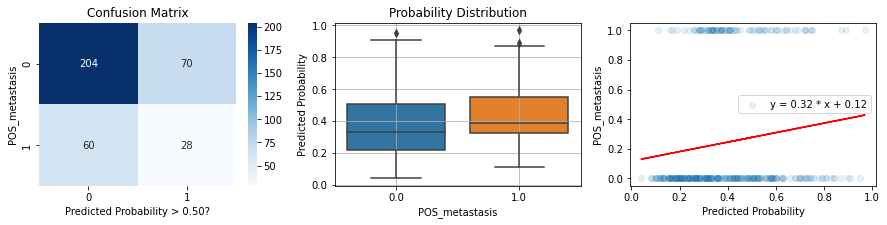

Only with susp LN
--------------------------------------------------
Prediction Probability Threshold: 0.5
Classification Report: 
              precision    recall  f1-score   support

      metas-       0.58      0.54      0.56        72
      metas+       0.60      0.64      0.62        77

    accuracy                           0.59       149
   macro avg       0.59      0.59      0.59       149
weighted avg       0.59      0.59      0.59       149

AUC: 0.5973


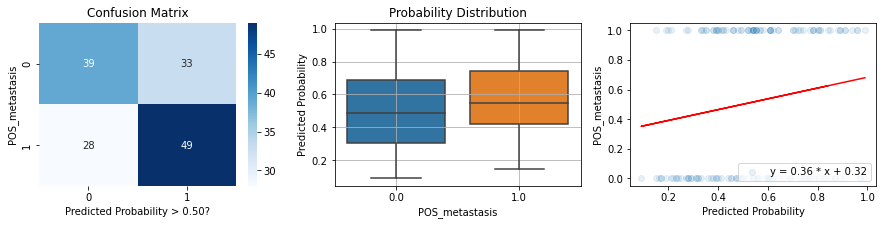

Both with and without susp LN
--------------------------------------------------
Prediction Probability Threshold: 0.5
Classification Report: 
              precision    recall  f1-score   support

      metas-       0.73      0.70      0.72       346
      metas+       0.43      0.47      0.45       165

    accuracy                           0.63       511
   macro avg       0.58      0.58      0.58       511
weighted avg       0.64      0.63      0.63       511

AUC: 0.6476


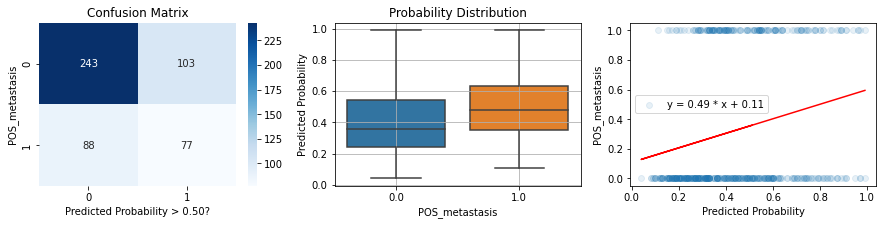

In [62]:
# Import modules for calculating the metrics of prediction
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# Import libraries for plotting heatmaps and box plots  
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None


def evaluate_predictions(df: pd.DataFrame, pred_col: str, truth_col: str, threshold: float, title: str, show_results=False):
    # Convert pred_col to float type
    df[pred_col] = df[pred_col].astype(float)
    # Convert pred_col to binary 1 or 0 based on threshold, save the binary pred_col_binary, using .loc to suppress warnings
    df[pred_col_binary] = df[pred_col] > threshold
    # df.loc[df[pred_col] > threshold, pred_col_binary] = 1
    # df.loc[df[pred_col] <= threshold, pred_col_binary] = 0
    # Filter the df by having non-nan values for the nomogram probability
    df_nomogram = df[~df[pred_col].isna()]
    # Replace the "3" values (unknown) in the truth column with np.nan using .loc
    df_nomogram.loc[df_nomogram[truth_col] == 3, truth_col] = np.nan
    # Replace the "2" values (absent) in the truth column with 0 using .loc
    df_nomogram.loc[df_nomogram[truth_col] == 2, truth_col] = 0
    # Filter df_nomogram by having non-nan values for the metastasis
    df_nomogram = df_nomogram[~df_nomogram[truth_col].isna()]
    # Print target value count

    # Assert there's no nan values in the nomogram probability or the metastasis columns
    assert df_nomogram[pred_col].isna().sum() == 0
    assert df_nomogram[truth_col].isna().sum() == 0
    # Calculate the accuracy, sensitivity, specificity, F1, and AUC metrics
    accuracy = accuracy_score(df_nomogram[truth_col], df_nomogram[pred_col_binary])
    sensitivity = recall_score(df_nomogram[truth_col], df_nomogram[pred_col_binary])
    # specificity = recall_score(df_nomogram[~df_nomogram[truth_col].isna()][truth_col], df_nomogram[~df_nomogram[truth_col].isna()][pred_col_binary])
    cls_report = classification_report(df_nomogram[truth_col], df_nomogram[pred_col_binary], zero_division=0, target_names=["metas-", "metas+"])
    # specificity = recall_score(df_nomogram[~df_nomogram[truth_col]], df_nomogram[~df_nomogram[pred_col]])
    f1 = f1_score(df_nomogram[truth_col], df_nomogram[pred_col_binary], average="weighted")
    auc_score = roc_auc_score(df_nomogram[truth_col], df_nomogram[pred_col])
    # print(f"Accuracy: {round(accuracy, 4)}")
    # print(f"Sensitivity: {round(sensitivity, 4)}")
    # print(f"Specificity: {specificity}")
    # print(f"F1: {round(f1, 4)}")
    if show_results:
        print(title)
        # Create subplot with two plots side by side
        fig, ax = plt.subplots(1, 3, figsize=(15, 3))
        # Plot the confusion matrix with big font size
        cm = confusion_matrix(df_nomogram[truth_col], df_nomogram[pred_col_binary], labels=[0, 1])
        sns.heatmap(cm, annot=True, ax=ax[0], fmt="d", cmap="Blues")
        ax[0].set_title("Confusion Matrix")
        ax[0].set_xlabel(f"Predicted Probability > {threshold:.2f}?")
        ax[0].set_ylabel(truth_col)
        # Plot the box plot for each class of truth_col
        sns.boxplot(x=truth_col, y=pred_col, data=df_nomogram, ax=ax[1])
        # Add gridlines to the box plot
        ax[1].grid(True)
        ax[1].set_title("Probability Distribution")
        ax[1].set_xlabel(truth_col)
        ax[1].set_ylabel("Predicted Probability")
        print("-"*50)
        print(f"Prediction Probability Threshold: {threshold}")
        print(f"Classification Report: \n{cls_report}")
        print(f"AUC: {round(auc_score, 4)}")
        # Add a scatter plot of the true and predicted probabilities, fit regression line
        temp_x, temp_y = df_nomogram[pred_col], df_nomogram[truth_col]
        plt.scatter(temp_x, temp_y, alpha=0.1)
        # Regression coefficients using np.polyfit
        slope, intercept = np.polyfit(temp_x, temp_y, 1)
        # Plot regression line
        plt.plot(temp_x, intercept + slope * temp_x, 'r')
        label = f"y = {slope:.2f} * x + {intercept:.2f}"
        # Add label as a legend
        ax[2].legend([label])
        # Axis labels
        ax[2].set_xlabel("Predicted Probability")
        ax[2].set_ylabel(truth_col)
        plt.show()
    return accuracy, sensitivity, f1, auc_score

# Find the optimal probability threshold for the nomogram column where a high probability in PRE_sln_met_nomogram_prob should indicate POS_metastasis
def find_threshold(df, metric="accuracy"):
    best_metric = 0
    best_threshold = 0
    for i in range(0, 100, 1):
        threshold = i / 100
        accuracy, sensitivity, f1, auc_score = evaluate_predictions(df, pred_col, truth_col, threshold, f"Nomogram Probability Threshold: {threshold}")
        if metric == "accuracy":
            if accuracy > best_metric:
                best_metric = accuracy
                best_threshold = threshold
        elif metric == "f1":
            if f1 > best_metric:
                best_metric = f1
                best_threshold = threshold
        else:
            raise ValueError("metric must be either 'accuracy' or 'f1'")
    print(f"Best Threshold: {best_threshold}")
    return best_threshold


# Filter the dataframe by having non-nan values in nomogram_cols
# Print NaN value count in the nomogram_cols
print(f"Total number of rows: {len(df)}")
for col in nomogram_cols:
    print(f"{col}: {df[col].isna().sum()}")

# df = df[~df[nomogram_cols].isna().any(axis=1)]

for pred_col in ["PRE_sln_met_nomogram_prob", ]
pred_col = 
truth_col = "POS_metastasis"
threshold = 0.50
threshold_metric = "f1"
do_find_threshold = False
if do_find_threshold:
    # Create a subset of df with where PRE_susp_LN_prsnt_composite == 0 or 3 or nan
    df_no_susp_ln = df.loc[df["PRE_susp_LN_prsnt_composite"].isin([0, 3, np.nan])]
    evaluate_predictions(df_no_susp_ln, pred_col, truth_col, find_threshold(df_no_susp_ln, threshold_metric), "Only without susp LN", show_results=True)
    # Create a subset of df with only the patients with susp LN using .loc, where value == 1
    df_susp_ln = df.loc[df["PRE_susp_LN_prsnt_composite"] == 1]
    evaluate_predictions(df_susp_ln, pred_col, truth_col, find_threshold(df_susp_ln, threshold_metric), "Only with susp LN", show_results=True)
    # Evaluate on the entire dataset
    evaluate_predictions(df, pred_col, truth_col, find_threshold(df, metric=threshold_metric), "Both with and without susp LN", show_results=True)
else:
    # Create a subset of df with where PRE_susp_LN_prsnt_composite == 0 or 3 or nan
    df_no_susp_ln = df.loc[df["PRE_susp_LN_prsnt_composite"].isin([0, 3, np.nan])]
    evaluate_predictions(df_no_susp_ln, pred_col, truth_col, 0.5, "Only without susp LN", show_results=True)
    # Create a subset of df with only the patients with susp LN using .loc, where value == 1
    df_susp_ln = df.loc[df["PRE_susp_LN_prsnt_composite"] == 1]
    evaluate_predictions(df_susp_ln, pred_col, truth_col, 0.5, "Only with susp LN", show_results=True)
    # Evaluate on the entire dataset
    evaluate_predictions(df, pred_col, truth_col, 0.5, "Both with and without susp LN", show_results=True)

# Scratch Work Area

In [ ]:
# # Clear webform

# def test_fill(nomogram_fields):
#     global os_type

#     clear_field = nomogram_fields["Clear"]
#     click(clear_field.webform_x_coord, clear_field.webform_y_coord)
#     time.sleep(0.5)
#     click(clear_field.webform_x_coord, clear_field.webform_y_coord)
#     time.sleep(5)

#     for field in nomogram_fields.values():
#         field_name = field.web_field_name
#         field_type = field.web_field_type
#         if field_type == FieldType.CLEAR:
#             continue
#         webform_x_coord, webform_y_coord = field.webform_x_coord, field.webform_y_coord
#         print(f"The field type of {field_name} is {field_type}")
#         if field_type == FieldType.TEXTAREA:
#             if field_name == "Current Age":
#                 value = "50"
#             else:
#                 value = "1"
#             doubleClick(webform_x_coord, webform_y_coord, interval=0.2)
#             time.sleep(0.1)
#             typewrite(value)
#         elif field_type == FieldType.CHECKBOX:
#             if field_name in ["Multifocality?", "Tumor is confined to UIQ?"]:
#                 value = "Yes"
#             else:
#                 value = "No"
#             if value == "Yes":
#                 click(webform_x_coord, webform_y_coord)
#         elif field_type == FieldType.DROPDOWN:
#             if field_name == "Tumor Type and Grade":
#                 value = "Ductal, II"
#             elif field_name == "Estrogen-Receptor Status":
#                 value = "Negative"
#             else:
#                 value = "Positive"
#             click(webform_x_coord, webform_y_coord)
#             time.sleep(0.1)
#             option_x_coord, option_y_coord = field.get_dropdown_option_coords(value)
#             time.sleep(0.1)
#             click(option_x_coord, option_y_coord)
#         elif field_type == FieldType.CALCULATE:
#             click(webform_x_coord, webform_y_coord)
#             time.sleep(1)
#         elif field_type == FieldType.RESULT:
#             time.sleep(1)
#             top_left_coords = field.result_coords["top_left"]
#             bottom_right_coords = field.result_coords["bottom_right"]
#             moveTo(top_left_coords.x, top_left_coords.y)
#             time.sleep(0.1)
#             dragTo(bottom_right_coords.x, bottom_right_coords.y, duration=0.2, button="left")
#             if os_type == "Windows":
#                 hotkey("ctrl", "c") 
#             elif os_type == "Mac":
#                 hotkey("command", "c")
#             time.sleep(0.5)
#             result = pyperclip.paste()
#             if "%" in result:
#                 result = result.replace("%", "")
#                 result = round(float(result) / 100, 3)
#                 pyperclip.copy(result)
#             print(f"The resulting probability is {result}")
#             break
#         else:
#             raise Exception(f"Unknown field type: {field_type}")
#         # Press tab to clear auto-completes
#         time.sleep(0.1)
#         press("tab")
#     time.sleep(5)
    
# # test_fill(nomogram_fields)